In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import PCA

import torch
from torch import tensor as tt

from utils import *
from torch_models import *

from ipywidgets import interact


In [3]:
def make_design_matrix(cell_identifiers):
    """A function to create a generic design matrix from cell identifiers

    For example:
    input, cell_identifiers = [1,1,1,2,2,2]
    output, design_matrix: [[1,1,1,0,0,0][0,0,0,1,1,1]]

    Arguments
    ---------
    cell_identifiers: torch tensor
        List of cells identifiers, should be of type torch.int

    Returns
    -------
    design_matrix: torch tensor
        Design matrix of shape (num_cells, num_unique_identifiers)

    """
    design_matrix = torch.hstack(
        [
            (cell_identifiers == v).type(torch.float).reshape(len(cell_identifiers), 1)
            for i, v in enumerate(torch.unique(cell_identifiers))
        ]
    )
    return design_matrix

In [4]:
# load dataset
scData = pd.read_csv("data/190923_Neuron_1.csv")
scData = scData.T
col_names = scData.iloc[0, :].values
# delete first row

scData = scData.drop(scData.index[0])
scData.columns = col_names
scData["Vip"].mean()

# create anndata object
E_sc = anndata.AnnData(scData)
E_sc.X = E_sc.X.astype(float)

In [6]:
# load daset
time = pd.read_csv("data/190923_Neuron_1_metadata.csv")

labels = time["labels"].values
phase_inf = time["phase_inf"].values

# add to the anndata object
E_sc.obs["labels"] = labels
E_sc.obs["phase_inf"] = phase_inf
#filtering stuff
E_sc

AnnData object with n_obs × n_vars = 3473 × 11231
    obs: 'labels', 'phase_inf'

In [5]:
# take the index of scData it's a list of strings
# split every string by '_' and take the first element, fro the first element remove lettter X
# and then convert to int
# this is the sample index
sample_index = np.array(
    [int(s.split("_")[0][1:]) for s in E_sc.obs.index.values.tolist()]
)
sample_index


array([14, 14, 14, ..., 58, 58, 58])

In [6]:
# remove columns/genes with all zeros
E_sc = E_sc[:, E_sc.X.sum(axis=0) != 0]
# normalize per cell
E_sc.layers["norm"] = E_sc.X / E_sc.X.sum(axis=1).reshape(-1, 1)
# now standardize the data
E_sc.layers["stand"] = (
    E_sc.layers["norm"] - E_sc.layers["norm"].mean(axis=0)
) / E_sc.layers["norm"].std(axis=0)
E_sc.obs["counts"] = E_sc.X.sum(axis=1)

In [7]:
# load the fitted coef
coef_3D = pd.read_csv(
    "fit/theta_3D_big.csv",
)
zonated_genes = coef_3D["Unnamed: 0"].values
theta_3D = coef_3D.values[:, 1:]
theta_3D = theta_3D.astype(float)
theta_3D.shape

(68, 7)

In [8]:
# these genes are not in the dataset
not_include = ['Gm42418', 'Gm26917', 'Gapdh', 'Ptp4a1', 'Fam196a', 'Chd3os', 'Prokr2']
# create mask of genes that are not in the dataset
# and remove them from the list
mask_sc = np.array([z not in not_include for z in zonated_genes])
print(mask_sc.sum())
# remove them from the list
sc_zon = zonated_genes[mask_sc]
theta_3D = theta_3D[mask_sc, :]

sc_small = E_sc[:, sc_zon]
NC, NG = sc_small.shape

61


In [9]:
sc_small.layers["norm"].astype(float)
corr_cells = np.corrcoef(sc_small.layers["norm"].astype(float))
corr_genes = np.corrcoef(sc_small.layers["norm"].astype(float).T)

## finding seed values for x,y,z

In [10]:
# here  I create the mask_z which filters out cells with NO spatial infromation
# zero counts for all zonated genes

zonated_counts = sc_small.X.sum(axis=1)
mask_z = zonated_counts != 0
print(mask_z.sum())
# now remove cells that have zeros in all zonated genes
sc_small = sc_small[mask_z, :]

labelss = labels[mask_z]
phase_infs = phase_inf[mask_z]



3473


In [11]:
# create the design matrix
DM = make_design_matrix(tt(labelss))
NS = DM.shape[1]


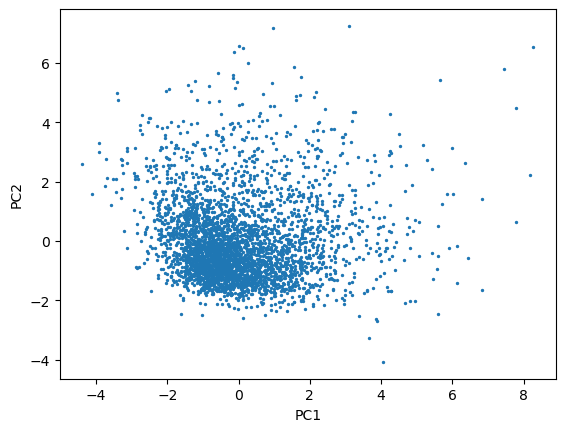

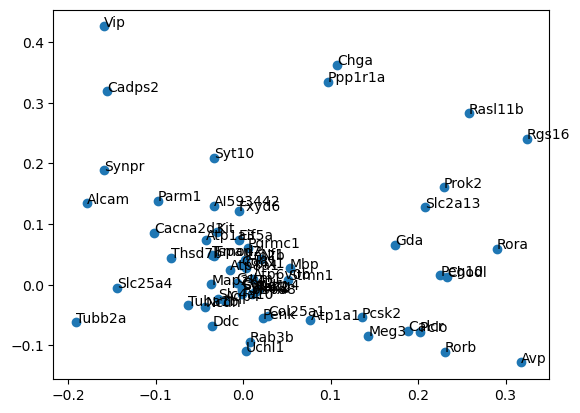

In [12]:
# perform PCA and plot the first 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(sc_small.layers["stand"])
vec = pca.components_

# plot the first 2 components
plt.scatter(PC[:, 0], PC[:, 1], s=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# plot the loadings of the first 2 components
plt.scatter(vec[0, :], vec[1, :])
# now annotate with gene names
for i, g in enumerate(sc_zon):
    plt.annotate(g, (vec[0, i], vec[1, i]))

In [13]:
# print mean, and variance for the normalized cut of every gene, next to the gene name
for i, g in enumerate(sc_zon):
    print(g, sc_small[:, g].layers["norm"].mean(), sc_small[:, g].layers["norm"].var())


Vip 0.003625200484753833 0.00010614709775601193
Mbp 0.00036082732472512497 7.080009434252302e-07
Meg3 0.0019466577015015663 3.4703544284501456e-06
Pgrmc1 0.0017521533959382446 3.0001472203840723e-06
Rorb 0.0004982927280896929 1.111146736339567e-06
Hspa8 4.443816653569726e-05 6.67860118686459e-08
Ndrg4 0.0004967722915228116 7.841088309412659e-07
Atp1a3 0.0003067806133124609 4.6529911945959457e-07
Rgs16 0.0006937280278146173 1.9060904926640925e-06
Syt10 0.0007902239450883602 1.4928806161056937e-06
Synpr 0.00017435038201636227 3.7670771907821685e-07
Rora 0.000827646199687356 1.904959405345252e-06
Cd81 0.0004904948195436809 8.088940268444937e-07
Tspan7 0.0002760279753343293 4.323284050808656e-07
Rasl11b 0.000244456845525767 5.916288419447586e-07
Peg10 0.00021247418502766893 5.243439127018757e-07
Pclo 0.0006704685461182439 1.4941571537569338e-06
Prok2 5.74166786022145e-05 1.6045260386920854e-07
Cadps2 0.0004820381636632021 8.911920540968629e-07
Penk 0.00018533432754194251 7.936764411158158e

## trying to order cells

Maybe choose more expressed genes with less zeros????

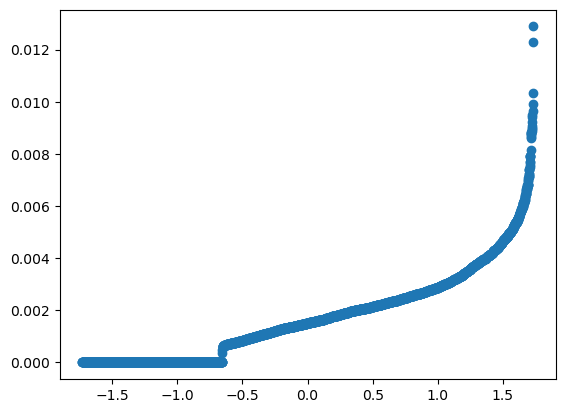

In [60]:
# now take a gene that grow MONOTONICALLY in space and get the argsort. This will give the order of the cells
# after standardize this position vecotr

# get the order of the cells
order_z = np.argsort(np.argsort(sc_small[:, "Pgrmc1"].layers["norm"].squeeze()))
z_guess = (order_z - order_z.mean()) / order_z.std()

plt.scatter(z_guess, sc_small[:, "Pgrmc1"].layers["norm"])

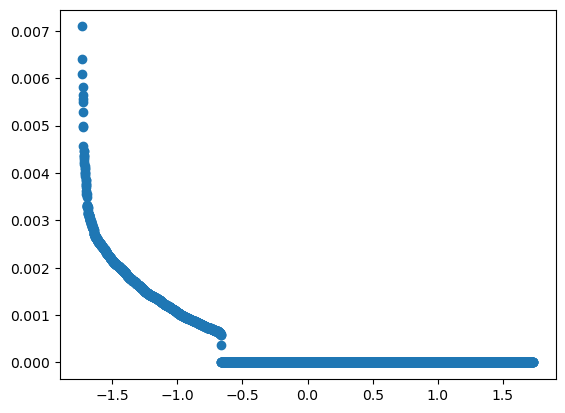

In [62]:
# same for y with gene Ndrg4
order_y = np.argsort(np.argsort(sc_small[:, "Ndrg4"].layers["norm"].squeeze()))
#here I put a negative sign tobecause the gene is DECREASES from the center to the periphery
y_guess = -(order_y - order_y.mean()) / order_y.std()

plt.scatter(y_guess, sc_small[:, "Ndrg4"].layers["norm"])

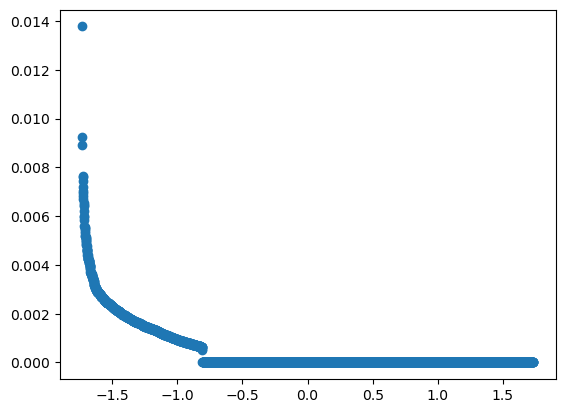

In [64]:
# same for x with gene Rorb
order_x = np.argsort(np.argsort(sc_small[:, "Rorb"].layers["norm"].squeeze()))
x_guess = -(order_x - order_x.mean()) / order_x.std()

plt.scatter(x_guess, sc_small[:, "Rorb"].layers["norm"])

# torch

In [65]:
# non leaf vectors
Y = tt(sc_small[:, :].layers["norm"])
Y_counts = tt(sc_small[:, :].X)
sc_counts = tt(sc_small.obs["counts"].values, dtype=torch.float32)


In [70]:
X = torch.randn(Y.shape[0], 3, requires_grad=True)
X = tt([x_guess, y_guess, z_guess]).T
X.requires_grad = True
# create X form the guesses

theta3 = tt(theta_3D)
# convert onated dataset to tesor

disp = tt(0.3, requires_grad=True)

# # gettign the constant and preparing the C parameter
# C = theta_3D[:,6].astype(np.dtype('float32'))
# C = tt(C)
# # repeat this vector N_sample ona  new dimension
# C = C.repeat(NS, 1)
# C.requires_grad = True


In [71]:
def model_3D_NB_batch(X, Y, theta, n_count, disp, batch_size=64):
    """
    model that given the expressiony and the parameters theta
    returns the expected value of the expression. To do so it needs to
    optimize the position-parameter x. Than we un least square loss to fit the model
    """
    NC = Y.shape[0]
    idx = torch.randperm(NC)[:batch_size]

    lmbda = (
          theta[:, 0][None, :] * X[idx, 0][:, None] ** 2
        + theta[:, 1][None, :] * X[idx, 0][:, None]
        + theta[:, 2][None, :] * X[idx, 1][:, None] ** 2
        + theta[:, 3][None, :] * X[idx, 1][:, None]
        + theta[:, 4][None, :] * X[idx, 2][:, None] ** 2
        + theta[:, 5][None, :] * X[idx, 2][:, None]
        + theta[:, 6][None, :] 
    )

    lmbda = torch.exp(lmbda) * n_count[idx, None]
    alpha = torch.exp(disp)

    r = 1 / alpha
    p = alpha * lmbda / (1 + alpha * lmbda)

    NB = torch.distributions.NegativeBinomial(
        total_count=r, probs=p, validate_args=None
    )

    return -NB.log_prob(Y[idx, :]).sum() * (NC / batch_size)

model_3D_NB_batch(X, Y_counts, theta3, sc_counts, disp, batch_size=64)

tensor(181171.8499, dtype=torch.float64, grad_fn=<MulBackward0>)

In [72]:
# train model
optimizer = torch.optim.Adam([X, disp], lr=0.001)

losses = []

for step in range(5000):
    optimizer.zero_grad()  # zero the gradients
    # output = model_2D(X, Y, theta3)
    output = model_3D_NB_batch(X, Y_counts, theta3, sc_counts, disp, batch_size=NC)
    #output = model_2D_DM(X, Y_counts, theta3, C, disp, sc_counts, DM, batch_size=64)

    output.backward()  # compute the gradients
    optimizer.step()  # update the variable
    losses.append(output.detach())

disp  0.775505
tensor(149737.7843, dtype=torch.float64)


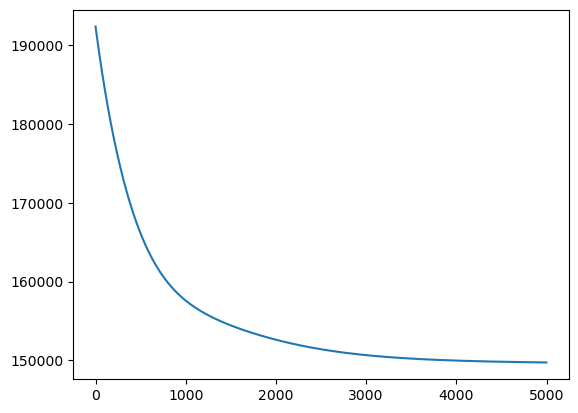

In [73]:
print("disp ", disp.detach().numpy())
print(losses[-1])
plt.plot(losses[0000:])

In [74]:
x_train = X.clone().detach().numpy()
# C_train = C.clone().detach().numpy()
model_2D_NB(X, Y_counts, theta3, sc_counts, disp)



tensor(710001.9945, dtype=torch.float64, grad_fn=<NegBackward0>)

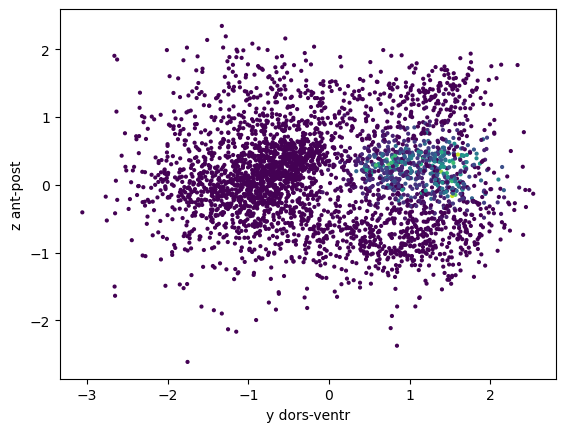

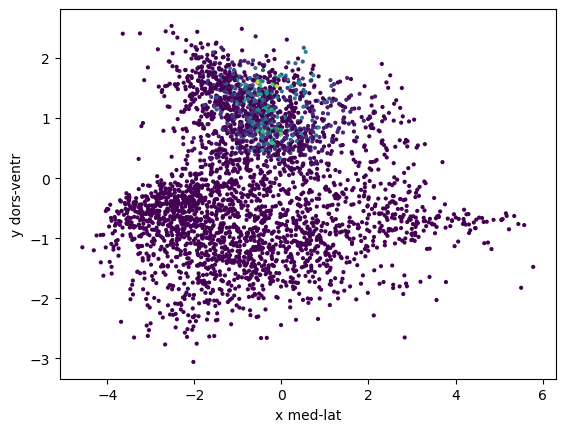

Text(0, 0.5, 'z ant-post')

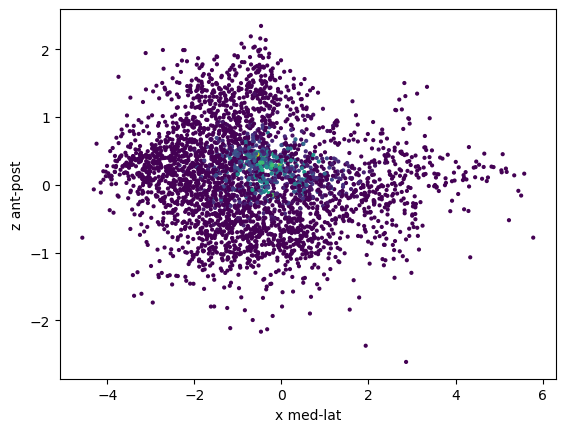

In [83]:
space_labels = np.array(["med-lat", "dors-vent", "ant-post"])

plt.scatter(
    x_train[:, 1], x_train[:, 2], c=sc_small[:, "Vip"].layers["norm"].squeeze(), s=4
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")
plt.show()

# now x and y
plt.scatter(
    x_train[:, 0], x_train[:, 1], c=sc_small[:, "Vip"].layers["norm"].squeeze(), s=4
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("x med-lat")
plt.ylabel("y dors-ventr")
plt.show()

# now x and z
plt.scatter(
    x_train[:, 0], x_train[:, 2], c=sc_small[:, "Vip"].layers["norm"].squeeze(), s=4
)
plt.xlabel("x med-lat")
plt.ylabel("z ant-post")
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)

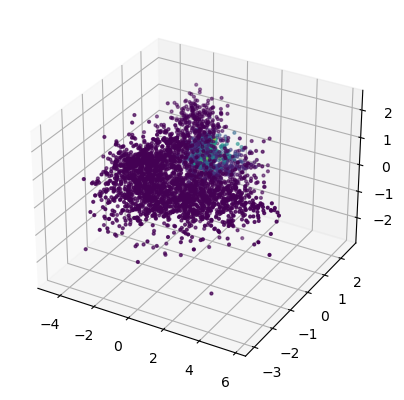

In [77]:
# plot x , y , z points in 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    x_train[:, 0],
    x_train[:, 1],
    x_train[:, 2],
    c=sc_small[:, "Vip"].layers["norm"].squeeze(),
    s=4,
)

In [78]:
x_mean = x_train.mean(axis=0)
x_mean

# now plot the mean of the cells
# this function uses the mean of the y positiion
# to than do a 1D plot of E(x,y)
def f_x(x, y_cost, theta, gene):
    E = np.exp(
        theta[0] * x ** 2 + theta[1] * x + theta[2] * y_cost ** 2 + theta[3] * y_cost + theta[4]
    )

In [ ]:
# plot the new x with expression of all zonated genes
# and plot the predicted fit line

for i, g in enumerate(sc_zon):
    plt.figure(figsize=(10, 5))
    plt.suptitle(g)
    plt.subplot(1, 2, 1)
    plt.scatter(x_train[:, 0], sc_small[:, g].layers["norm"], s=2)
    plt.xlabel("y dors-ventr")
    plt.ylabel("expression")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:, 1], sc_small[:, g].layers["norm"], s=2)
    plt.xlabel("z ant-post")
    plt.ylabel("expression")

    plt.show()

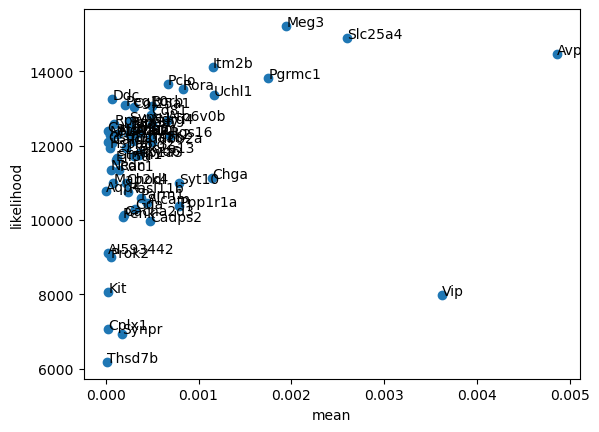

In [80]:
like = model_2D_NB_like(x_train, Y_counts, theta3, sc_counts, disp)
like_g = like.sum(axis=0).detach().numpy()

# plot now the likelihood per gene vs the gene mean
plt.scatter(sc_small[:, :].layers["norm"].mean(axis=0), like_g)
# now add annotations
for i, g in enumerate(sc_zon):
    plt.annotate(g, (sc_small[:, :].layers["norm"].mean(axis=0)[i], like_g[i]))


plt.xlabel("mean")
plt.ylabel("likelihood")
plt.show()

# phases

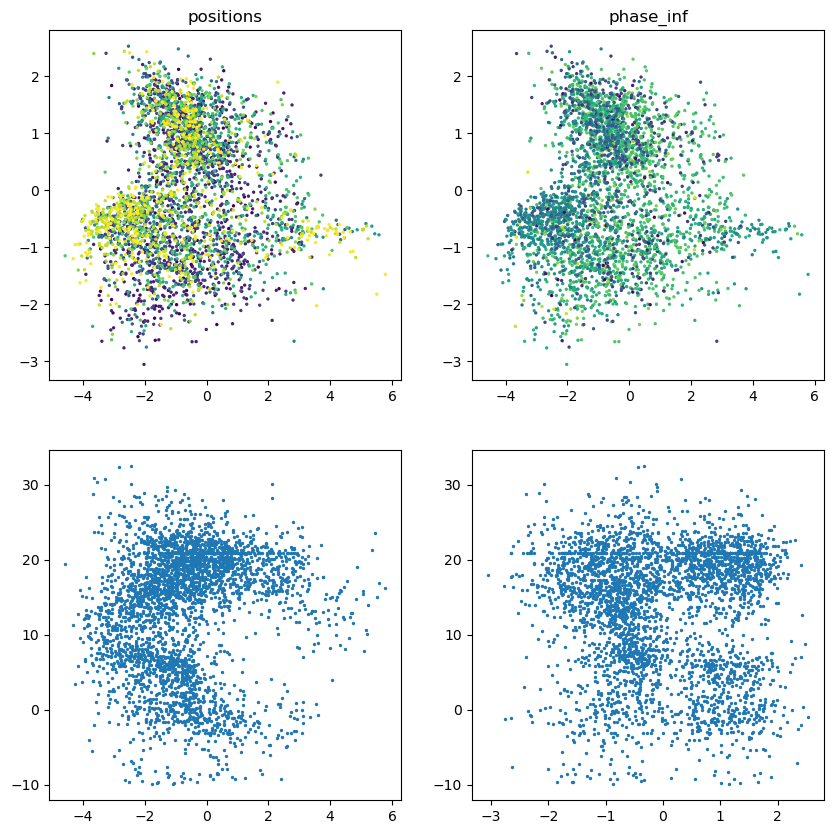

In [84]:
# quadruple plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(x_train[:, 0], x_train[:, 1], c=labelss, s=2)
axs[0, 0].set_title("positions")

axs[0, 1].scatter(x_train[:, 0], x_train[:, 1], c=phase_infs, s=2)
axs[0, 1].set_title("phase_inf")

axs[1, 0].scatter(x_train[:, 0], phase_infs, s=2)
axs[1, 1].scatter(x_train[:, 1], phase_infs, s=2)

In [28]:
# for i in np.unique(labels):
#     mask = labels == i
#     plt.scatter(x_train[mask, 0], x_train[mask, 1], s=5)
#     plt.xlabel("y dors-ventr")
#     plt.ylabel("z ant-post")
#     plt.title("14")
#     plt.show()

In [29]:
r_genes = [
    "Per1",
    "Per2",
    "Cry1",
    "Nr1d1",
    "Nr1d2",
    "Dbp",
    "Nfil3",
    "Tef",
    "Hlf",
    "Bhlhe41",
    "Ciart",
]
E_per = E_sc[:, r_genes]
labels.shape
E_per.X.sum(axis=0)

array([ 277.,  203.,  243.,  319.,  285.,  719.,   39.,  310., 1053.,
        145.,   20.])

Text(0.5, 0, 'time')

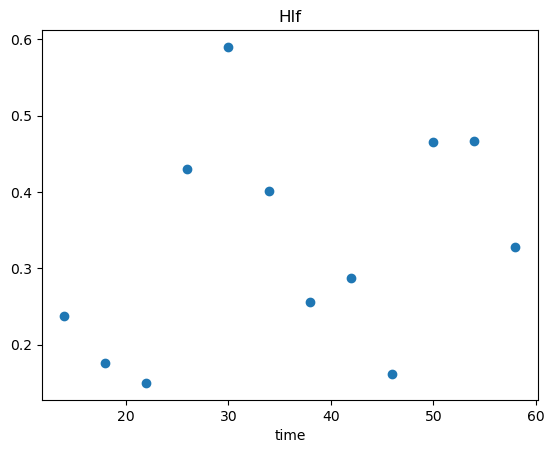

In [30]:
# plot label vs expression of Per1
# take an aavarage of the expression of Per1 for every label

def gene_pos(adata ,gene_name, obs_field="x"):
    v = adata[:, gene_name].X
    pos = adata.obs[obs_field]
    pos_un = pos.unique()
    out = np.zeros(pos_un.shape)

    for i, p in enumerate(pos_un):
        out[i] = np.mean(v[pos == p])

    return out

gene = "Hlf"
# plot label vs expression of Per1
# take an aavarage of the expression of Per1 for every label
plt.scatter(np.unique(labels), gene_pos(E_per, gene, obs_field="labels") )
plt.title(gene)
plt.xlabel("time")


In [31]:
time_points = np.unique(labels)

In [32]:
# now I want the same kind of plot but with the real data
# the positions are given by x_train
# the expression wich will colour cells will be gene Cry1
# the time will be given by labelss

# first of all we want to 
gene = "Hlf"
def video(n):
    # n is teh index of the time point
    t = time_points[n]
    mask = labelss == t
    plt.figure(figsize=(10, 10))
    plt.title("t=" + str(t) + ' number of cells ' + str(mask.sum()))
    plt.scatter(x_train[mask, 0], x_train[mask, 1], c=E_sc[mask_z, gene][mask].layers['norm'], s=100)


interact(video, n=(0, len(time_points) - 1, 1))

interactive(children=(IntSlider(value=5, description='n', max=11), Output()), _dom_classes=('widget-interact',…

<function __main__.video(n)>